# Multi Index

Multi-indexing is a powerful feature in `DataFrame`s that allows to work 
efficiently with multi-dimensional data. 

The reason that the MultiIndex matters is that it can allow you to do grouping, selection, and reshaping operations. As you will see in later sections, you can find yourself working with hierarchically-indexed data without creating a MultiIndex explicitly yourself.

Topics Reviewed:

- DataFrame structure with Multi-index: index, columns, axis, levels
- Multi-index creation `.from_arrays()`, `.from_tuples()`, `.from_product()`
- Indexing and Slicing with Multi-index 
    - Basic Ideas: `.loc[<tuple1>,<tuple2>]`
    - Tuples, List, and Slicing : `.loc[<list of tuples>]` (or slicing), `.loc[<tuple of lists>]`
    - Partial Selection: `.loc[<label_on_first_level>]`,`df.loc(axis = 0)[]`, `.xs()`
- Function of Interest about Multi-index
    - `set_index()` and `reset_index()` can work together
    - `reindex()` (can also be used for broadcasting similar to `align()`)
    - `swaplevel()` and `reorder_levels()`
    - `rename`, `rename_axis`, `index.set_names`, `.set_axis()`

In [197]:
import pandas as pd
import numpy as np

np.random.seed(0)

In [198]:
## Handy function
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Multi-Index in a DataFrame

Multi-indexing is a powerful feature in `DataFrame`s that allows to work 
efficiently with multi-dimensional data. 

Instead of using multiple axes like in Numpy arrays, DataFrames utilize 
`index` and `columns` labels that are multi-indexes with different `levels`. 
    
This approach eliminates the need for multiple axes, simplifying the 
representation of multi-dimensional data in a two-dimensional `DataFrame`. 

Using Multi-index, we can identify distinct components within a DataFrame:

1. `index` are row label indentifiers
2. `columns` are column label indentifier
3. `axis` indicates the current dimension. 
    - `axis = 0` the index dim
    - `axis = 1` the columns dim
4. `levels` indicates the different layers of a multi-index. Note each level can be named.

<img src="./assets/imgs/multi_index_structure.png" width="500"/>

In [199]:
index = pd.MultiIndex.from_product(
    [["foo", "bar", "caz"], ["one", "two"]],
    names=["word", "number"]
)

columns = pd.MultiIndex.from_product(
    [["A","B"], ["age","weight","height"]],
    names=["letter", "feature"]
)

df = pd.DataFrame(
    data = np.random.randint(10, size = (6,6)),
    index=index,
    columns=columns
)
df


letter        A                 B              
feature     age weight height age weight height
word number                                    
foo  one      5      0      3   3      7      9
     two      3      5      2   4      7      6
bar  one      8      8      1   6      7      7
     two      8      1      5   9      8      9
caz  one      4      3      0   3      5      0
     two      2      3      8   1      3      3

In [200]:
print("Axes:", df.axes)
print("Row Levels: ", df.index.levels)
print("Column Levels: ", df.columns.levels)

Axes: [MultiIndex([('foo', 'one'),
            ('foo', 'two'),
            ('bar', 'one'),
            ('bar', 'two'),
            ('caz', 'one'),
            ('caz', 'two')],
           names=['word', 'number']), MultiIndex([('A',    'age'),
            ('A', 'weight'),
            ('A', 'height'),
            ('B',    'age'),
            ('B', 'weight'),
            ('B', 'height')],
           names=['letter', 'feature'])]
Row Levels:  [['bar', 'caz', 'foo'], ['one', 'two']]
Column Levels:  [['A', 'B'], ['age', 'height', 'weight']]


## Multi Index Creation

It is possible to create multindex in diferent ways. The most relevant are the 
folliwing.

1. `pd.MultiIndex.from_arrays()` creates multi-index from the pair-wise combination between two arrays.
2. `pd.MultiIndex.from_tuples()` creates multi-index from each tuple in a list of tuples.
3. `pd.MultiIndex.from_product()` creates multi-index between the cross combination between two arrays.

**NOTE:** it is possible to provided a list of list (or arrays) to the `index` paramater in `pd.DataFrame()` to create the multi-index similar to a `.from_arrays()` function.

**NOTE:** it is also possible to create a multi-index from a `DataFrame` with `pd.MultiIndex.from_frame()`

In [201]:
# 1. Multi-index from arrays
index = pd.MultiIndex.from_arrays(
    [
        ["one", "one", "two", "two", "three", "three"],
        ["foo", "bar", "foo", "bar", "foo", " bar"]
     ]
)

df = pd.DataFrame(np.arange(6), index=index)
df 

0
one   foo   0
      bar   1
two   foo   2
      bar   3
three foo   4
       bar  5

In [202]:
# NOTE: Creating a multi-index directly in the DataFrame
df = pd.DataFrame(np.arange(6),
                  index = [ ["one", "one", "two", "two", "three", "three"],
                            ["foo", "bar", "foo", "bar", "foo", " bar"]])
df

0
one   foo   0
      bar   1
two   foo   2
      bar   3
three foo   4
       bar  5

In [203]:
#2. Multi-index from tuples
index = pd.MultiIndex.from_tuples(
    [
        ("one","foo"),
        ("one","bar"),
        ("two","foo"),
        ("two","bar"),
        ("three","foo"),
        ("three","bar")
    ]
)

df = pd.DataFrame(np.arange(6), index=index)
df 

0
one   foo  0
      bar  1
two   foo  2
      bar  3
three foo  4
      bar  5

In [204]:
# 3. Multi-index from product
index = pd.MultiIndex.from_product(
    [
        ["one", "two", "three"],
        ["foo", "bar"]
    ]
)

df = pd.DataFrame(np.arange(6), index=index)
df 

0
one   foo  0
      bar  1
two   foo  2
      bar  3
three foo  4
      bar  5

## Indexing and Slicing with Multi Index

There are different ways for indexing a `DataFrame` with multi-index. The main idea is that
you can identify a particular multi-index row (or column) by a tuple containing the levels required

`(level0, level1, level2, ...)`

**NOTE:** `level0`, `level1`, and `level2` are the label indentifiers on each level, not the level names.

In such way, you can perform the following indexing:

1. `.loc[(level0, level1,)]` takes the row specified by `level0` and `level1` on index.
2. `.loc[:,(level0, level1,)]` takes the column specified by `level0` and `level1` on columns.
3. `.loc[(level0,level1),(level0,level1)]` takes the specific cell specified by `level0` and `level1` on index and `level0` and `level1` on columns.

<img src="./assets/imgs/multi_index_basic_indexing.png" width="600"/>

In [205]:
index = pd.MultiIndex.from_product(
    [["foo", "bar", "caz"], ["one", "two"]],
    names=["word", "number"]
)

columns = pd.MultiIndex.from_product(
    [["A","B"], ["age","weight","height"]],
    names=["letter", "feature"]
)

df = pd.DataFrame(
    data = np.random.randint(10, size = (6,6)),
    index=index,
    columns=columns
)
df


letter        A                 B              
feature     age weight height age weight height
word number                                    
foo  one      3      7      0   1      9      9
     two      0      4      7   3      2      7
bar  one      2      0      0   4      5      5
     two      6      8      4   1      4      9
caz  one      8      1      1   7      9      9
     two      3      6      7   2      0      3

In [206]:
# 1. indexing specific row
df.loc[("foo","one")]

letter  feature
A       age        3
        weight     7
        height     0
B       age        1
        weight     9
        height     9
Name: (foo, one), dtype: int64

In [207]:
# 2. indexing specific col
df.loc[:, ("A", "age")]

word  number
foo   one       3
      two       0
bar   one       2
      two       6
caz   one       8
      two       3
Name: (A, age), dtype: int64

In [208]:
# 4. indexing specific cell (row, col combination)
df.loc[("bar","two"),("B","height")]

9

### List, Tuples and Slicing

As common indexing, you can take values calling a **list of tuples**. Nonetheless, the multi-index also accepts
a **tuple of list**, which must not be confused with the list of tuples. 

1. `.loc[<list of tuple>]` takes the rows specified by the list of tuples on index.
2. `.loc[<tuple of lists>,:]` takes all rows resulting from the cross combination between the lists labels on index.
3. `.loc[(<tuple1>:<tuple2)]` (slicing) takes the rows from `tuple1` to `tuple2`. It is practically a list of tuples by comprenhension, similar to numpy. However, the index or columns labels **must be sorted in order to slice it**.

**NOTE**: you can also apply the previous techniques in columns.

<img src="./assets/imgs/multi_index_tuples_list_slicing.png" width="600"/>

In [209]:
#NOTE: the column labels are unsorted, then the slicing will return an error
#For that reason, we sorted the labels first
df = df.sort_index(axis=1)
df

letter        A                 B              
feature     age height weight age height weight
word number                                    
foo  one      3      0      7   1      9      9
     two      0      7      4   3      7      2
bar  one      2      0      0   4      5      5
     two      6      4      8   1      9      4
caz  one      8      1      1   7      9      9
     two      3      7      6   2      3      0

In [210]:
# 1. Indexing list of tuples
result = df.loc[[("foo","one"),("bar","two")]]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 bar 
 two 
 6 
 4 
 8 
 1 
 9 
 4

In [211]:
# 2. Indexing tuple of lists
# NOTE: it takes the cross combination betweewn both lists
result = df.loc[(["foo","bar"],["one","two"]),:]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4

In [212]:
#3. Indexing using slicing on tuples
#NOTE: it will take columns from ("A","height") to ("B","age")
result = df.loc[:,("A","height"):("B","age")]
display_side_by_side(df,result)


letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 height 
 weight 
 age 
 
 
 word 
 number 
 
 
 
 
 
 
 
 foo 
 one 
 0 
 7 
 1 
 
 
 two 
 7 
 4 
 3 
 
 
 bar 
 one 
 0 
 0 
 4 
 
 
 two 
 4 
 8 
 1 
 
 
 caz 
 one 
 1 
 1 
 7 
 
 
 two 
 7 
 6 
 2

### Partial Selection

Let say we are only interested in **picking a particular label in a given level** (not the tuple combination). To do that, you can select data by a “partial” label identifying a subgroup in the data. There are different ways to do it:

1. `.loc[level0]` selects all the rows specified by an indentifier only in the first level on index. However, this only works on the first level. Note you can also use slicing with this technique.
2. `.loc(axis=0)[<level0>,<level1>,<level2>, ...]` choses an axis, and then the content within the brackets (`[]`) works as you were indexing only in the levels of that axis.
3. `.xs(<label_on_level>, level = <level_name> , axis = 0)` choses level_name and axis, and then filters a particular label in that level and axis

**NOTE:** the three methods work for both index and column labels.

<img src="./assets/imgs/multi_index_partial_selection.png" width="600"/>

**NOTE:** it is also possible to make partial selection with the previous methods of list, tuples, and slicing. In fact, you can use a combination of tuples, list of tuples, tuple of lists, or slicing together with the first option.

**NOTE:** There are other metods that uses `slice()` or `pd.IndexSlice` for indexing the `DataFrame`. However, those methods are out of the scope of this tutorial.

In [213]:
# 1. indexing an specific label on level 0
# NOTE: we can also use slicing like "bar":"caz", but we first need to sort the index
result = df.loc["foo"]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 number 
 
 
 
 
 
 
 
 
 
 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2

In [214]:
# 1. indexing an specific label on level 0 (on columns)
result = df.loc[:,"A"]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 feature 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 
 
 two 
 0 
 7 
 4 
 
 
 bar 
 one 
 2 
 0 
 0 
 
 
 two 
 6 
 4 
 8 
 
 
 caz 
 one 
 8 
 1 
 1 
 
 
 two 
 3 
 7 
 6

In [215]:
# 2. indexing an specific label on any level
# NOTE: here we pick the label ="one" in the level 2
result = df.loc(axis=0)[:,"one"]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9

In [216]:
# 3. indexing an specific label on any level (USING .xs function)
# NOTE: here we pick the label ="one" in the level 2
# NOTE: it removes the level
result = df.xs("one", level="number")
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 
 
 
 
 
 
 
 
 
 
 foo 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 bar 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 caz 
 8 
 1 
 1 
 7 
 9 
 9

In [217]:
# Tuple and first option
result = df.loc[("foo","one"),"A"]
result

feature
age       3
height    0
weight    7
Name: (foo, one), dtype: int64

In [218]:
# List of tuples and first option
result = df.loc[[("foo","one"), ("bar","one")],"A"]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 feature 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 
 
 bar 
 one 
 2 
 0 
 0

In [219]:
# Tuple of lists and first option
result = df.loc[(["foo","bar"], ["one","two"]),"A"]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 
 feature 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 
 
 two 
 0 
 7 
 4 
 
 
 bar 
 one 
 2 
 0 
 0 
 
 
 two 
 6 
 4 
 8

In [220]:
# slicing and first option
result = df.loc["foo", ("A","age"):("B","age")]
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 foo 
 one 
 3 
 0 
 7 
 1 
 9 
 9 
 
 
 two 
 0 
 7 
 4 
 3 
 7 
 2 
 
 
 bar 
 one 
 2 
 0 
 0 
 4 
 5 
 5 
 
 
 two 
 6 
 4 
 8 
 1 
 9 
 4 
 
 
 caz 
 one 
 8 
 1 
 1 
 7 
 9 
 9 
 
 
 two 
 3 
 7 
 6 
 2 
 3 
 0 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 feature 
 age 
 height 
 weight 
 age 
 
 
 number 
 
 
 
 
 
 
 
 
 one 
 3 
 0 
 7 
 1 
 
 
 two 
 0 
 7 
 4 
 3

## Multi-index Functions of Interest

The following are some important functions that we could use when working with multi-index:

1. `set_index()` and `reset_index()` can work together
2. `reindex()` (can also be used for broadcasting similar to `align()`)
3. `swaplevel()` and `reorder_levels()`
4. `rename`, `rename_axis`, `index.set_names`, `.set_axis()`


In [221]:
index = pd.MultiIndex.from_product(
    [["bar", "caz","foo"], ["one", "two"]],
    names=["word", "number"]
)

columns = pd.MultiIndex.from_product(
    [["A","B"], ["age","height","weight"]],
    names=["letter", "feature"]
)

df = pd.DataFrame(
    data = np.arange(36).reshape(6,6) ,
    index=index,
    columns=columns
)
df


letter        A                 B              
feature     age height weight age height weight
word number                                    
bar  one      0      1      2   3      4      5
     two      6      7      8   9     10     11
caz  one     12     13     14  15     16     17
     two     18     19     20  21     22     23
foo  one     24     25     26  27     28     29
     two     30     31     32  33     34     35

### `set_index()` and `reset_index()`

- `set_index(keys = <column or columns names>)` sets the index using the column (or columns).
- `reset_index(level= <level or list of levels>)` resets the index (or a level in multi-index) and use the default index instead. 
    - By default, it reset all the levels in a multi-index.
    - When define a level, the other levels remain in the index.

In [222]:
# 1. use two columns to set index
result = df.set_index([("A","age"), ("B","age")])
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 height 
 weight 
 height 
 weight 
 
 
 (A, age) 
 (B, age) 
 
 
 
 
 
 
 
 
 0 
 3 
 1 
 2 
 4 
 5 
 
 
 6 
 9 
 7 
 8 
 10 
 11 
 
 
 12 
 15 
 13 
 14 
 16 
 17 
 
 
 18 
 21 
 19 
 20 
 22 
 23 
 
 
 24 
 27 
 25 
 26 
 28 
 29 
 
 
 30 
 33 
 31 
 32 
 34 
 35

In [223]:
# 2. reset index from multi-index
result = df.reset_index(level="number")
display_side_by_side(df, result)
print(result.columns)
# NOTE: the multi-index tuple for the new column is ('number', '')

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 letter 
 number 
 A 
 B 
 
 
 feature 
 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 bar 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 caz 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 foo 
 two 
 30 
 31 
 32 
 33 
 34 
 35

MultiIndex([('number',       ''),
            (     'A',    'age'),
            (     'A', 'height'),
            (     'A', 'weight'),
            (     'B',    'age'),
            (     'B', 'height'),
            (     'B', 'weight')],
           names=['letter', 'feature'])


In [224]:
# by default reset all the levels
result = df.reset_index()
display_side_by_side(df, result)


letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 letter 
 word 
 number 
 A 
 B 
 
 
 feature 
 
 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 
 
 0 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 1 
 bar 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 2 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 3 
 caz 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 4 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 5 
 foo 
 two 
 30 
 31 
 32 
 33 
 34 
 35

### `reindex()`

`.reindex(labels)` returns a new Series or DataFrame with the indexes
specified in `labels`. The complete function allow us to perform different
actions:

`.reindex(labels, axis, index, columns, level, fill_value)`

1. Filter rows specified by labels using `axis = 0` (default).
2. Filter cols specified by labels using `axis = 1`.
3. Filter rows and cols at the same time using `index` and `columns` parameters.
4. **IMPORTANT**: If the labels in `labels` parameter there are not in the DataFrame the values will be filled with NaN. 
5. Filling NaN with `fill_value`.
6. Broadcast values when using multi-index.
7. Align and broadcast values along a `level` (similar to `align()` function).


**NOTE:** the behavior of `.reindex()` is similar to indexing with a list of 
tuples, but `reindex()` has additional functionalities.

**NOTE:** **alignment vs brodcasting** 
- **alignment** between two DataFrames with different shapes returns two new DataFrames that share the same shape. This is gotten by completing the rows or cols that are missing in each other DataFrame (commonly completing with NaN values). 
- While **broadcasting** means to complete that NaN values repeating values presented in a given level.

In [225]:
# 1. Filter rows specified by labels using axis = 0 (default)
result = df.reindex(labels=[("bar","one"),("caz","two")])
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 caz 
 two 
 18 
 19 
 20 
 21 
 22 
 23

In [226]:
# 2. Filter columns specified by labels using axis = 1
result = df.reindex(
    labels = [("A","age"),("B", "age")],
    axis=1
)
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 age 
 
 
 word 
 number 
 
 
 
 
 
 
 bar 
 one 
 0 
 3 
 
 
 two 
 6 
 9 
 
 
 caz 
 one 
 12 
 15 
 
 
 two 
 18 
 21 
 
 
 foo 
 one 
 24 
 27 
 
 
 two 
 30 
 33

In [227]:
# 3. Filter index and columns at the same time
result = df.reindex(
    index = [("bar","one"),("caz","two")],
    columns= [("A","age"),("B", "age")]
)
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 age 
 
 
 word 
 number 
 
 
 
 
 
 
 bar 
 one 
 0 
 3 
 
 
 caz 
 two 
 18 
 21

In [228]:
# 4. IMPORTAN: if labels are not in original DataFrame returns NaN
result = df.reindex(
    labels = [("bar","one"),("caz","two"),("foo","three")],
)
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0.0 
 1.0 
 2.0 
 3.0 
 4.0 
 5.0 
 
 
 caz 
 two 
 18.0 
 19.0 
 20.0 
 21.0 
 22.0 
 23.0 
 
 
 foo 
 three 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN

In [229]:
# 3. Fill NaN with a given value
result = df.reindex(
    labels = [("bar","one"),("caz","two"),("foo","three")],
    fill_value = 0
)
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 caz 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 three 
 0 
 0 
 0 
 0 
 0 
 0

In [230]:
# 4. Broadcasting with multi-index
# By deafult when using multi-index, if you increase the tuple levels, you can
# broadcast the values thorugh the new created level
result = df.reindex(
    labels = pd.MultiIndex.from_tuples([('bar', 'one', 10),
              ('bar', 'one', "x"),
              ('bar', 'two', 10),
              ('bar', 'two', "x")])
)
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 
 
 bar 
 one 
 10 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 x 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 10 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 x 
 6 
 7 
 8 
 9 
 10 
 11

In [231]:
# 4. Align and broadcast values along a level
# NOTE: Suppose you want to rest the mean between "one" and "two" for each word 
# (["bar","caz","foo"]). Then, you need the exact shape as the orginal.
# The following code align values along the level 0 and broadcast the mean values

# Calculating mean along level 0
df2 = df.groupby(level=0).mean()

# Reindex using the original index to keep the shape (align) and broadcast using 
# level = 0
result = df2.reindex(df.index, level=0)

display_side_by_side(df, df2, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 
 
 
 
 
 
 
 
 
 
 bar 
 3.0 
 4.0 
 5.0 
 6.0 
 7.0 
 8.0 
 
 
 caz 
 15.0 
 16.0 
 17.0 
 18.0 
 19.0 
 20.0 
 
 
 foo 
 27.0 
 28.0 
 29.0 
 30.0 
 31.0 
 32.0 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 3.0 
 4.0 
 5.0 
 6.0 
 7.0 
 8.0 
 
 
 two 
 3.0 
 4.0 
 5.0 
 6.0 
 7.0 
 8.0 
 
 
 caz 
 one 
 15.0 
 16.0 
 17.0 
 18.0 
 19.0 
 20.0 
 
 
 two 
 15.0 
 16.0 
 17.0 
 18.0 
 19.0 
 20.0 
 
 
 foo 
 one 
 27.0 
 28.0 
 29.0 
 30.0 
 31.0 
 32.0 
 
 
 two 
 27.0 
 28.0 
 29.0 
 30.0 
 31.0 
 32.0

In [232]:
# NOTE: you can also use align to align and broadcast the mean

# Calculating mean along level 0
df2 = df.groupby(level=0).mean()

df_aligned, df2_aligned = df.align(df2, level=0)

display_side_by_side(df_aligned, df2_aligned)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 3.0 
 4.0 
 5.0 
 6.0 
 7.0 
 8.0 
 
 
 two 
 3.0 
 4.0 
 5.0 
 6.0 
 7.0 
 8.0 
 
 
 caz 
 one 
 15.0 
 16.0 
 17.0 
 18.0 
 19.0 
 20.0 
 
 
 two 
 15.0 
 16.0 
 17.0 
 18.0 
 19.0 
 20.0 
 
 
 foo 
 one 
 27.0 
 28.0 
 29.0 
 30.0 
 31.0 
 32.0 
 
 
 two 
 27.0 
 28.0 
 29.0 
 30.0 
 31.0 
 32.0

### `swaplevel()` and `reorder_levels()`

Both function with reorder levels on a multi-index.

- `swaplevel(<level_i>, <level_j>, axis)` will switch two levels along an axis.
- `reorder_levels(<list_of_levels>, axis)` is a more generic ways to reorder all the levels along an axis

In [233]:
index = pd.MultiIndex.from_product(
    [
        ["bar", "caz"],
        ["one", "two"],
        ["x", "y"]
    ]
)

df = pd.DataFrame(
    data = np.random.randint(10, size=(8,2)),
    index = index,
    columns = ["A", "B"]
)
df

A  B
bar one x  5  9
        y  4  4
    two x  6  4
        y  4  3
caz one x  4  4
        y  8  4
    two x  3  7
        y  5  5

In [234]:
# swaping two levels
# level 0 and level 1
result = df.swaplevel(0, 1, axis=0)
display_side_by_side(df, result)

A 
 B 
 
 
 
 
 bar 
 one 
 x 
 5 
 9 
 
 
 y 
 4 
 4 
 
 
 two 
 x 
 6 
 4 
 
 
 y 
 4 
 3 
 
 
 caz 
 one 
 x 
 4 
 4 
 
 
 y 
 8 
 4 
 
 
 two 
 x 
 3 
 7 
 
 
 y 
 5 
 5 
 
 
 
 
 
 
 
 
 A 
 B 
 
 
 
 
 one 
 bar 
 x 
 5 
 9 
 
 
 y 
 4 
 4 
 
 
 two 
 bar 
 x 
 6 
 4 
 
 
 y 
 4 
 3 
 
 
 one 
 caz 
 x 
 4 
 4 
 
 
 y 
 8 
 4 
 
 
 two 
 caz 
 x 
 3 
 7 
 
 
 y 
 5 
 5

In [235]:
# reordering level generalizes swaplevel
result = df.reorder_levels([2,1,0], axis= 0)
display_side_by_side(df, result)

A 
 B 
 
 
 
 
 bar 
 one 
 x 
 5 
 9 
 
 
 y 
 4 
 4 
 
 
 two 
 x 
 6 
 4 
 
 
 y 
 4 
 3 
 
 
 caz 
 one 
 x 
 4 
 4 
 
 
 y 
 8 
 4 
 
 
 two 
 x 
 3 
 7 
 
 
 y 
 5 
 5 
 
 
 
 
 
 
 
 
 A 
 B 
 
 
 
 
 x 
 one 
 bar 
 5 
 9 
 
 
 y 
 one 
 bar 
 4 
 4 
 
 
 x 
 two 
 bar 
 6 
 4 
 
 
 y 
 two 
 bar 
 4 
 3 
 
 
 x 
 one 
 caz 
 4 
 4 
 
 
 y 
 one 
 caz 
 8 
 4 
 
 
 x 
 two 
 caz 
 3 
 7 
 
 
 y 
 two 
 caz 
 5 
 5

### `rename`, `rename_axis`, `index.set_names`, `.set_axis()`

These are functions to rename the labels or the level names. All these functions share similar objectives, but some of them accepts `dict`, `list` or even `MultiIndex`. In order to clarify, these behaviors I elaborate the following table:

| Method                        | Parameters                              | Description                                                                                                                                                 | Argument Type                  |
|-------------------------------|-----------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------|
| `rename()`                    | `index`, `columns` or `mapper`, `axis`   | Renames index or column labels using a dictionary mapping or a callable mapper.                                                                              | `dict` or `callable`           |
| `rename_axis()`               | `index`, `columns` or `mapper`, `axis`   | Renames index or column level names using a dictionary mapping or a list of new names.                                                                             | `dict` or `list`               |
| `Index.set_names()`           | `names`                                 | Sets new names for the levels of an Index using a dictionary mapping or a list of new names.                                                                                                                   | `list` or `dict`               |
| `set_axis()`                  | `labels`, `axis` | Sets new labels for the specified axis of the DataFrame, either using a list of new labels, an Index, or a MultiIndex.                                      | `list`, `Index`, or `MultiIndex` |


**NOTE:** From previous function, only the `.set_names()` works directly on the `Index` object, the other ones work on the `DataFrame`.

In [236]:
index = pd.MultiIndex.from_product(
    [["bar", "caz","foo"], ["one", "two"]],
    names=["word", "number"]
)

columns = pd.MultiIndex.from_product(
    [["A","B"], ["age","height","weight"]],
    names=["letter", "feature"]
)

df = pd.DataFrame(
    data = np.arange(36).reshape(6,6) ,
    index=index,
    columns=columns
)
df

letter        A                 B              
feature     age height weight age height weight
word number                                    
bar  one      0      1      2   3      4      5
     two      6      7      8   9     10     11
caz  one     12     13     14  15     16     17
     two     18     19     20  21     22     23
foo  one     24     25     26  27     28     29
     two     30     31     32  33     34     35

In [252]:
# 1. renaming index and column labels
# NOTE: you only need to specify the label, the level doesn't matter
result = df.rename(
    columns={"A": "X", "B":"Y", "age": "year"},
    index={"bar": 10, "caz": 20, "foo": 30}
)
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 letter 
 X 
 Y 
 
 
 
 feature 
 year 
 height 
 weight 
 year 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 10 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 20 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 30 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35

In [238]:
# NOTE: you can also specified the dict (mapper) + axis
result = df.rename(
    mapper = {"A": "X", "B":"Y", "age": "year"},
    axis = 1
)
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 letter 
 X 
 Y 
 
 
 
 feature 
 year 
 height 
 weight 
 year 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35

In [239]:
# 2. renaming index and column levels
result = df.rename_axis(
    index = ["WORD", "NUMBER"],
    columns = ["LETTER", "FEATURE"]
)
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 LETTER 
 A 
 B 
 
 
 
 FEATURE 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 WORD 
 NUMBER 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35

In [240]:
# NOTE: you can also specified a dictionary
result = df.rename_axis(
    index = {"word": "WORD"},
    columns = {"letter": "LETTER"}
)
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 LETTER 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 WORD 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35

In [241]:
# NOTE: you can also specified a list (mapper) + axis
result = df.rename_axis(
    mapper = ["LETTER", "FEATURE"],
    axis=1
)
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 LETTER 
 A 
 B 
 
 
 
 FEATURE 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35

In [242]:
# 3. rename levels directly from index
result = df.copy()
result.columns = result.columns.set_names(["LETTER", "FEATURE"])
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 LETTER 
 A 
 B 
 
 
 
 FEATURE 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35

In [243]:
#NOTE: you can also use dicts
result = df.copy()
result.columns = result.columns.set_names({"letter":"LETTER"})
display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 LETTER 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35

In [250]:
# 4. renaming all the axis at once
# NOTE: set_axis can accept a list 
result = df.set_axis(
    labels = range(6),
    axis = 1
    )

display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35

In [249]:
# NOTE: set_axis can also accepts a given index or multi-index
index = pd.MultiIndex.from_product([["X","Y"],[10, 20, 30]])
result = df.set_axis(
    labels= index,
    axis = 1
    )

display_side_by_side(df, result)

letter 
 A 
 B 
 
 
 
 feature 
 age 
 height 
 weight 
 age 
 height 
 weight 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35 
 
 
 
 
 
 
 
 X 
 Y 
 
 
 
 
 10 
 20 
 30 
 10 
 20 
 30 
 
 
 word 
 number 
 
 
 
 
 
 
 
 
 
 
 bar 
 one 
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 two 
 6 
 7 
 8 
 9 
 10 
 11 
 
 
 caz 
 one 
 12 
 13 
 14 
 15 
 16 
 17 
 
 
 two 
 18 
 19 
 20 
 21 
 22 
 23 
 
 
 foo 
 one 
 24 
 25 
 26 
 27 
 28 
 29 
 
 
 two 
 30 
 31 
 32 
 33 
 34 
 35

## Database-style DataFrame (`join()` and `merge()`)
Pandas has full-featured, high performance in-memory join operations idiomatically very similar to relational databases like SQL. 

## `merge()`

Accepts a left and right `DataFrame` or `named Series` objects

You can use it as 

`pd.merge(df1, df2)` or `df1.merge(df2)`

The related `join()` method, uses merge internally for the index-on-index (by default) and column(s)-on-index join.

In [3]:
left = pd.DataFrame(
    {
        "key1": ["K0", "K0", "K1", "K2"],
        "key2": ["K0", "K1", "K0", "K1"],
        "A": ["A0", "A1", "A2", "A3"],
        "B": ["B0", "B1", "B2", "B3"],
    }
)
left

,key1,key2,A,B
0,K0,K0,A0,B0
1,K0,K1,A1,B1
2,K1,K0,A2,B2
3,K2,K1,A3,B3


In [5]:
right = pd.DataFrame(
    {
        "key1": ["K0", "K1", "K1", "K2"],
        "key2": ["K0", "K0", "K0", "K0"],
        "C": ["C0", "C1", "C2", "C3"],
        "D": ["D0", "D1", "D2", "D3"],
    }
)
right

,key1,key2,C,D
0,K0,K0,C0,D0
1,K1,K0,C1,D1
2,K1,K0,C2,D2
3,K2,K0,C3,D3


In [6]:
result = pd.merge(left, right, on=["key1", "key2"])
result

,key1,key2,A,B,C,D
0,K0,K0,A0,B0,C0,D0
1,K1,K0,A2,B2,C1,D1
2,K1,K0,A2,B2,C2,D2


In [14]:
result = pd.merge(left, right, on=["key1", "key2"], how="left")
display_side_by_side(left, result)

key1 
 key2 
 A 
 B 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 
 
 1 
 K0 
 K1 
 A1 
 B1 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 
 
 3 
 K2 
 K1 
 A3 
 B3 
 
 
 
 
 
 
 key1 
 key2 
 A 
 B 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 C0 
 D0 
 
 
 1 
 K0 
 K1 
 A1 
 B1 
 NaN 
 NaN 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 C1 
 D1 
 
 
 3 
 K1 
 K0 
 A2 
 B2 
 C2 
 D2 
 
 
 4 
 K2 
 K1 
 A3 
 B3 
 NaN 
 NaN

In [15]:
result = pd.merge(left, right, on=["key1", "key2"], how="right")
display_side_by_side(right, result)

key1 
 key2 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 C0 
 D0 
 
 
 1 
 K1 
 K0 
 C1 
 D1 
 
 
 2 
 K1 
 K0 
 C2 
 D2 
 
 
 3 
 K2 
 K0 
 C3 
 D3 
 
 
 
 
 
 
 key1 
 key2 
 A 
 B 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 C0 
 D0 
 
 
 1 
 K1 
 K0 
 A2 
 B2 
 C1 
 D1 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 C2 
 D2 
 
 
 3 
 K2 
 K0 
 NaN 
 NaN 
 C3 
 D3

In [18]:
result = pd.merge(left, right, on=["key1", "key2"], how="outer")
display_side_by_side(left, right, result)

key1 
 key2 
 A 
 B 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 
 
 1 
 K0 
 K1 
 A1 
 B1 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 
 
 3 
 K2 
 K1 
 A3 
 B3 
 
 
 
 
 
 
 key1 
 key2 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 C0 
 D0 
 
 
 1 
 K1 
 K0 
 C1 
 D1 
 
 
 2 
 K1 
 K0 
 C2 
 D2 
 
 
 3 
 K2 
 K0 
 C3 
 D3 
 
 
 
 
 
 
 key1 
 key2 
 A 
 B 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 C0 
 D0 
 
 
 1 
 K0 
 K1 
 A1 
 B1 
 NaN 
 NaN 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 C1 
 D1 
 
 
 3 
 K1 
 K0 
 A2 
 B2 
 C2 
 D2 
 
 
 4 
 K2 
 K1 
 A3 
 B3 
 NaN 
 NaN 
 
 
 5 
 K2 
 K0 
 NaN 
 NaN 
 C3 
 D3

In [20]:
result = pd.merge(left, right, how="cross")
display_side_by_side(left, right, result)

key1 
 key2 
 A 
 B 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 
 
 1 
 K0 
 K1 
 A1 
 B1 
 
 
 2 
 K1 
 K0 
 A2 
 B2 
 
 
 3 
 K2 
 K1 
 A3 
 B3 
 
 
 
 
 
 
 key1 
 key2 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 C0 
 D0 
 
 
 1 
 K1 
 K0 
 C1 
 D1 
 
 
 2 
 K1 
 K0 
 C2 
 D2 
 
 
 3 
 K2 
 K0 
 C3 
 D3 
 
 
 
 
 
 
 key1_x 
 key2_x 
 A 
 B 
 key1_y 
 key2_y 
 C 
 D 
 
 
 
 
 0 
 K0 
 K0 
 A0 
 B0 
 K0 
 K0 
 C0 
 D0 
 
 
 1 
 K0 
 K0 
 A0 
 B0 
 K1 
 K0 
 C1 
 D1 
 
 
 2 
 K0 
 K0 
 A0 
 B0 
 K1 
 K0 
 C2 
 D2 
 
 
 3 
 K0 
 K0 
 A0 
 B0 
 K2 
 K0 
 C3 
 D3 
 
 
 4 
 K0 
 K1 
 A1 
 B1 
 K0 
 K0 
 C0 
 D0 
 
 
 5 
 K0 
 K1 
 A1 
 B1 
 K1 
 K0 
 C1 
 D1 
 
 
 6 
 K0 
 K1 
 A1 
 B1 
 K1 
 K0 
 C2 
 D2 
 
 
 7 
 K0 
 K1 
 A1 
 B1 
 K2 
 K0 
 C3 
 D3 
 
 
 8 
 K1 
 K0 
 A2 
 B2 
 K0 
 K0 
 C0 
 D0 
 
 
 9 
 K1 
 K0 
 A2 
 B2 
 K1 
 K0 
 C1 
 D1 
 
 
 10 
 K1 
 K0 
 A2 
 B2 
 K1 
 K0 
 C2 
 D2 
 
 
 11 
 K1 
 K0 
 A2 
 B2 
 K2 
 K0 
 C3 
 D3 
 
 
 12 
 K2 
 K1 
 A3 
 B3 
 K0 
 K0 
 C0 
 D0 
 
 
 13 
 K2 
 K1 
 A3 
 B3 
 K1 
 K0 
 C1 
 D1 
 
 
 14 
 K2 
 K1 
 A3 
 B3 
 K1 
 K0 
 C2 
 D2 
 
 
 15 
 K2 
 K1 
 A3 
 B3 
 K2 
 K0 
 C3 
 D3

In [21]:
ser = pd.Series(
    ["a", "b", "c", "d", "e", "f"],
    index=pd.MultiIndex.from_arrays(
        [["A", "B", "C"] * 2, [1, 2, 3, 4, 5, 6]], names=["Let", "Num"]
    ),
)
ser

Let  Num
A    1      a
B    2      b
C    3      c
A    4      d
B    5      e
C    6      f
dtype: object

In [22]:
ser.reset_index()

,Let,Num,0
0,A,1,a
1,B,2,b
2,C,3,c
3,A,4,d
4,B,5,e
5,C,6,f


**Warning:** Joining / merging on duplicate keys can cause a returned frame that is the multiplication of the row dimensions, which may result in memory overflow. It is the user’ s responsibility to manage duplicate values in keys before joining large DataFrames.

In [24]:
left = pd.DataFrame({"A": [1, 2], "B": [2, 2]})

right = pd.DataFrame({"A": [4, 5, 6], "B": [2, 2, 2]})

result = pd.merge(left, right, on="B", how="outer")

display_side_by_side(left, right, result)

# este ejercicio me hace dudar todo lo que entendi antes

A 
 B 
 
 
 
 
 0 
 1 
 2 
 
 
 1 
 2 
 2 
 
 
 
 
 
 
 A 
 B 
 
 
 
 
 0 
 4 
 2 
 
 
 1 
 5 
 2 
 
 
 2 
 6 
 2 
 
 
 
 
 
 
 A_x 
 B 
 A_y 
 
 
 
 
 0 
 1 
 2 
 4 
 
 
 1 
 1 
 2 
 5 
 
 
 2 
 1 
 2 
 6 
 
 
 3 
 2 
 2 
 4 
 
 
 4 
 2 
 2 
 5 
 
 
 5 
 2 
 2 
 6

In [25]:

result = pd.merge(left, right, on="B", how="inner")

display_side_by_side(left, right, result)

A 
 B 
 
 
 
 
 0 
 1 
 2 
 
 
 1 
 2 
 2 
 
 
 
 
 
 
 A 
 B 
 
 
 
 
 0 
 4 
 2 
 
 
 1 
 5 
 2 
 
 
 2 
 6 
 2 
 
 
 
 
 
 
 A_x 
 B 
 A_y 
 
 
 
 
 0 
 1 
 2 
 4 
 
 
 1 
 1 
 2 
 5 
 
 
 2 
 1 
 2 
 6 
 
 
 3 
 2 
 2 
 4 
 
 
 4 
 2 
 2 
 5 
 
 
 5 
 2 
 2 
 6

If a string matches both a column name and an index level name, then a warning is issued and the column takes precedence. This will result in an ambiguity error in a future version.

**Note**: the non-unique keys problem that I didn't understand happens because
there are overlapping cases where for example

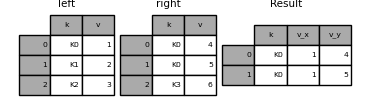

If we want to 'inner' merge using k as key we encounter overlapping in the values
of v because

1. left has K0 1
2. right has K0 3 and K0 4

Then, the overlapping is solve by adding two columns at the resultin merged df
as v_x and v_y

v_x for the left values of column v and v_y for the right values of column v

In [29]:
df1 = pd.DataFrame({"v": [1, 2, 3]}, index=["K0", "K1", "K2"])
df2 = pd.DataFrame({"v": [4, 5, 6]}, index=["K0", "K0", "K3"])
df3 = pd.DataFrame({"v": [7, 8, 9]}, index=["K1", "K1", "K2"])

result = df1.join([df2, df3])

display_side_by_side(df1, df2, df3, result)


,v
K0,1
K1,2
K2,3
,v
K0,4
K0,5
K3,6
,v
K1,7
K1,8


In [31]:
#the idea of combine_first is to have two data frames that are similar in the sense
# that they have same index and columns (not necessarily all of them)
# and you want to "patch" or fill some nan values from left with the values
# from right.

df1 = pd.DataFrame(
    [[np.nan, 3.0, 5.0], [-4.6, np.nan, np.nan], [np.nan, 7.0, np.nan]]
)


df2 = pd.DataFrame([[-42.6, np.nan, -8.2], [-5.0, 1.6, 4]], index=[1, 2])

result = df1.combine_first(df2)

display_side_by_side(df1, df2, result)

,0,1,2
0,NaN,3.0,5.0
1,-4.6,NaN,NaN
2,NaN,7.0,NaN
,0,1,2
1,-42.6,NaN,-8.2
2,-5.0,1.6,4.0
,0,1,2
0,NaN,3.0,5.0
1,-4.6,NaN,-8.2
2,-5.0,7.0,4.0


In [33]:
# related method that alterate the NaN values in place
# but replace all the values from right into the left structure
df1.update(df2)
df1

,0,1,2
0,NaN,3.0,5.0
1,-42.6,NaN,-8.2
2,-5.0,1.6,4.0
